In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
model_name='short_description-60k'
# model_name='full-30k'
# model_name='samlple-30k'

In [5]:
path=Path('data')

In [6]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet')

In [10]:
df_train = df_raw[df_raw['lang'] == 'en']
df_test = df_raw_test[df_raw_test['lang'] == 'en']

In [11]:
df_all = df_train[['short_description']].append(df_test[['short_description']])

In [13]:
# max_vocab = 60k by default - seting it to lower value to make training faster
# txt_proc = [TokenizeProcessor(), NumericalizeProcessor(vocab=None, max_vocab=30000)]
# data_lm = (TextList.from_df(df_all, path=path, processor=txt_proc)
# data_lm = (TextList.from_df(df_all, path=path)
#            .split_by_rand_pct(0.05)
#            .label_for_lm()
#            .databunch(bs=192)
#           )
# print(f'Vocabulary size {len(data_lm.vocab.itos)}')

Vocabulary size 41642


In [16]:
# data_lm.save(f'data-lm-{model_name}.pkl')

In [6]:
bs = 128 # 128 = 12502MiB

In [7]:
data_lm = load_data(path, f'data-lm-{model_name}.pkl', bs=bs)

### LM Training

In [10]:
learn_nlp = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


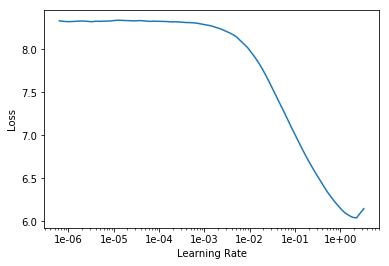

In [22]:
learn_nlp.lr_find(); learn_nlp.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.402354,2.200191,0.596743,05:36
1,2.454032,2.228348,0.592196,05:37
2,2.332588,2.118111,0.601674,05:36
3,2.147641,1.968947,0.622994,05:36
4,2.051376,1.916668,0.629986,05:37


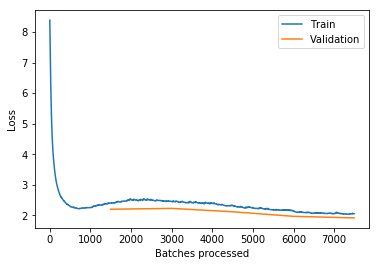

In [23]:
learn_nlp.fit_one_cycle(5, 5e-2, moms=(0.8,0.7)); learn_nlp.recorder.plot_losses()

In [24]:
learn_nlp.save(f'lm-{model_name}-1')

In [9]:
learn_nlp.load(f'lm-{model_name}-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1540520 items)
x: LMTextList
xxbos opstechit - xxup hou2 xxmaj project opstechit xxmaj manual opstechit xximpacthigh xxmaj equipment xxmaj request ( xxmaj new / xxmaj loaner ) xxup hou2 - xxup fc ( xxmaj houston , xxup tx ) xxmaj sort - xxup ar xxup houston xxup us xxup hou2 xxup tx xxmaj client xxmaj devices xxup hou2 - xxmaj singles problem solve request xxmaj building i d : xxup hou2 xxmaj workflow name : opstechit_devices_and_equipment_other xxmaj description : xxmaj problem xxmaj solve xxmaj stations on xxmaj line 3 , 4 , & 5 as well as xxmaj audit at xxmaj slam 6 in xxmaj pack xxmaj singles need to be fully setup as problem solve & xxmaj pack xxmaj stations . xxmaj each location must be fully functional for problem solve to pack out items . xxmaj in addition to work tables , equipment needed : xxmaj tape xxmaj dispensers , xxmaj dunnage xxmaj machines , xxmaj full xxmaj box xxmaj suites , xxmaj spoo xxmaj machines , p - xxm

In [25]:
learn_nlp.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


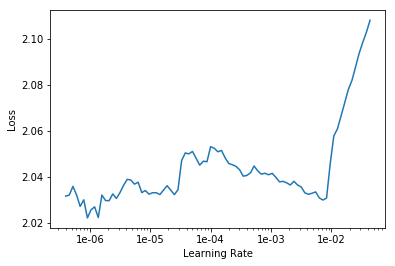

In [26]:
learn_nlp.lr_find(end_lr=1e-1); learn_nlp.recorder.plot()

In [27]:
learn_nlp.fit_one_cycle(5, 3e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.910488,1.847955,0.639485,06:24
1,1.846823,1.790050,0.648207,06:24
2,1.796844,1.762389,0.652413,06:24
3,1.777602,1.750189,0.654199,06:24
4,1.773471,1.748087,0.654497,06:25


In [28]:
learn_nlp.save(f'lm-{model_name}-tuned')

In [12]:
learn_nlp.save_encoder(f'{model_name}-tuned-enc')

### Test

In [29]:
TEXT = "Device xxhost"
N_WORDS = 10
N_SENTENCES = 10
print("\n".join(learn_nlp.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Device xxhost failed Audit xxbos IT Storage Check
Device xxhost failed Audit xxbos [ xxkiosk METRIC ]
Device xxhost failed Audit xxbos RF Scanner TOA
Device xxhost failed Audit xxbos RMA Audit xxbos i
Device xxhost failed Audit xxbos Weekly IDF -
Device xxhost failed Audit xxbos Incoming Admin request xxbos
Device xxhost failed Audit xxbos Defect Detected at
Device xxhost failed Audit xxbos Printer in Not
Device xxhost failed Audit xxbos Laptop Off Computer
Device xxhost failed Audit xxbos Incoming Comp access xxbos
